### FGSM 공격
- 정상 이미지에 노이즈를 더해 머신러닝 모델을 헷갈리게 하는 이미지가 바로 적대적 예제(Adversarial Example)
- Fast Gradient Sign Method, 즉 줄여서 FGSM이라는 방식으로 적대적 예제를 생성해 미리 학습이 완료된 딥러닝 모델을 공격

In [2]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
import json
import matplotlib.pyplot as plt

#### 학습된 모델

In [3]:
model = models.resnet101(pretrained=True)
model.eval()
print(model)

c:\Users\perso\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\perso\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to C:\Users\perso/.cache\torch\hub\checkpoints\resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:03<00:00, 57.1MB/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### 데이터셋

In [4]:
CLASSES = json.load(open('./imagenet_samples/imagenet_classes.json'))
idx2class = [CLASSES[str(i)] for i in range(1000)]

#### 이미지 불러오기

In [5]:
# 이미지 불러오기
img = Image.open('./imagenet_samples/corgie.jpg')

In [6]:
# 이미지를 텐서로 변환하기
img_transforms = transforms.Compose([
    transforms.Resize((224, 224), Image.BICUBIC),
    transforms.ToTensor(),
])

img_tensor = img_transforms(img)
img_tensor = img_tensor.unsqueeze(0)

print("이미지 텐서 모양:", img_tensor.size())

이미지 텐서 모양: torch.Size([1, 3, 224, 224])


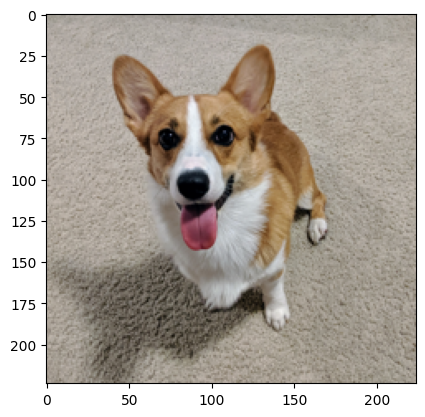

In [7]:
# 시각화를 위해 넘파이 행렬 변환
original_img_view = img_tensor.squeeze(0).detach()  # [1, 3, 244, 244] -> [3, 244, 244]
original_img_view = original_img_view.transpose(0,2).transpose(0,1).numpy()

# 텐서 시각화
plt.imshow(original_img_view)

#### 공격 전 성능 확인

In [8]:
output = model(img_tensor)
prediction = output.max(1, keepdim=False)[1]

prediction_idx = prediction.item()
prediction_name = idx2class[prediction_idx]

print("예측된 레이블 번호:", prediction_idx)
print("레이블 이름:", prediction_name)

예측된 레이블 번호: 263
레이블 이름: Pembroke, Pembroke Welsh corgi


#### FGSM 공격 함수 정의

In [9]:
def fgsm_attack(image, epsilon, gradient):
    # 기울기값의 원소의 sign 값을 구함
    sign_gradient = gradient.sign()
    # 이미지 각 픽셀의 값을 sign_gradient 방향으로 epsilon 만큼 조절
    perturbed_image = image + epsilon * sign_gradient
    # [0,1] 범위를 벗어나는 값을 조절
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

#### 적대적 예제 생성

In [10]:
# 이미지의 기울기값을 구하도록 설정
img_tensor.requires_grad_(True)

# 이미지를 모델에 통과시킴
output = model(img_tensor)

# 오차값 구하기 (레이블 263은 웰시코기)
loss = F.nll_loss(output, torch.tensor([263])) 

# 기울기값 구하기
model.zero_grad()
loss.backward()

# 이미지의 기울기값을 추출
gradient = img_tensor.grad.data

# FGSM 공격으로 적대적 예제 생성
epsilon = 0.03
perturbed_data = fgsm_attack(img_tensor, epsilon, gradient)

# 생성된 적대적 예제를 모델에 통과시킴
output = model(perturbed_data)

In [11]:
output

tensor([[-2.9696e+00,  9.6703e-02, -9.8262e-01, -5.8920e-01,  6.9453e-01,
          2.8003e-01,  6.8028e-01, -2.6476e+00, -2.2739e+00, -6.7569e-01,
         -1.0068e+00, -3.9445e-02, -1.4696e+00, -1.3078e-01, -2.0723e+00,
         -2.4486e+00, -1.4856e+00, -1.4979e+00, -5.9645e-01, -9.5461e-01,
         -2.5813e+00, -1.9565e-01, -7.9697e-01,  5.1700e-01, -2.1765e+00,
         -1.7026e+00, -1.9471e+00, -1.6739e+00, -1.2337e+00, -1.3993e+00,
         -1.0745e+00, -4.6808e-01, -1.8550e+00,  3.2880e-01, -1.4687e-01,
         -1.7658e+00, -8.1568e-01, -8.1632e-01,  8.1701e-01, -2.4874e+00,
         -1.2654e+00, -1.5896e+00, -3.9849e-01, -2.5620e+00, -1.4090e+00,
          2.0099e-02,  1.1293e+00,  6.1778e-01, -1.0453e+00, -2.7099e+00,
         -4.0828e-01, -1.7365e+00, -9.9076e-01, -2.3419e+00, -5.3513e-01,
         -1.1144e+00, -2.0396e+00, -2.4892e+00, -1.0188e+00, -1.1580e+00,
         -2.4719e-01, -7.1322e-01, -1.6650e+00, -5.5175e-01, -7.0700e-01,
         -8.5174e-02, -3.0542e-01,  4.

#### 적대적 예제 성능 확인

In [12]:
perturbed_prediction = output.max(1, keepdim=True)[1]

perturbed_prediction_idx = perturbed_prediction.item()
perturbed_prediction_name = idx2class[perturbed_prediction_idx]

print("예측된 레이블 번호:", perturbed_prediction_idx)
print("레이블 이름:", perturbed_prediction_name)

예측된 레이블 번호: 172
레이블 이름: whippet


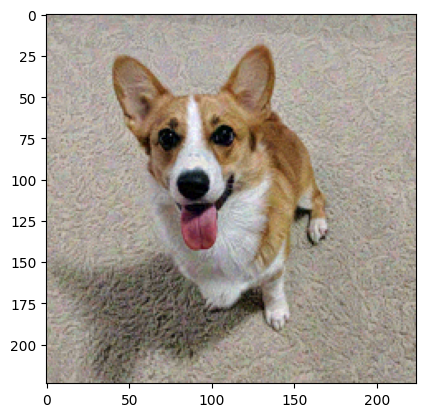

In [13]:
# 시각화를 위해 넘파이 행렬 변환
perturbed_data_view = perturbed_data.squeeze(0).detach()
perturbed_data_view = perturbed_data_view.transpose(0,2).transpose(0,1).numpy()

plt.imshow(perturbed_data_view)

#### 원본과 적대적 예제 비교

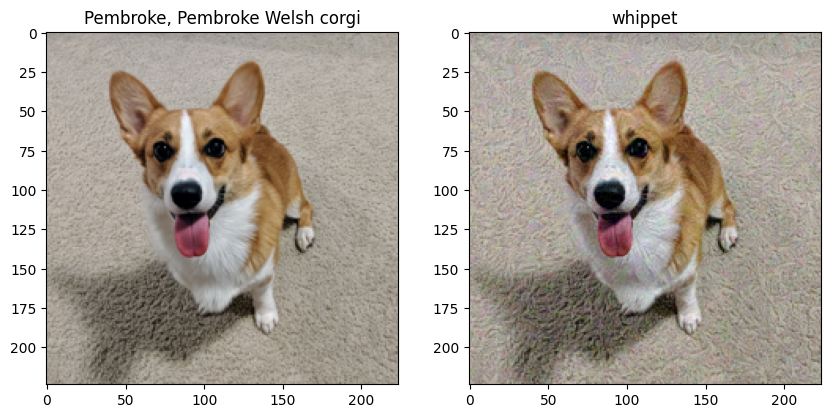

In [14]:
f, a = plt.subplots(1, 2, figsize=(10, 10))

# 원본
a[0].set_title(prediction_name)
a[0].imshow(original_img_view)

# 적대적 예제
a[1].set_title(perturbed_prediction_name)
a[1].imshow(perturbed_data_view)

plt.show()
